In [30]:
import sys
sys.path.append('../code/') 
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import BaseMetricLossFunction

import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from hnn_core.utils import smooth_waveform
from scipy.signal import savgol_filter
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

from contrastive_functions import SEE_Dataset

In [31]:
cam_idx = 1
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/', kinematic_suffix=f'_cam{cam_idx}')
num_trials = len(kinematic_df['trial'].unique())

null_percent = kinematic_df.groupby('name')['posData'].apply(list).map(
    np.concatenate).map(lambda x: np.sum(np.isnan(x)) / len(x))

pos_filter = [1, 4]
# pos_filter = [1,2,3,4]
pos_remove_filter = [f'position_{pos_idx}' for pos_idx in [2,3]]
# pos_remove_filter = [f'position_{pos_idx}' for pos_idx in []]

# layout_filter = [1,2,3,4]
layout_filter = [1,2]

# layout_remove_filter = [f'layout_{layout_idx}' for layout_idx in [3,4]]
layout_remove_filter = [f'layout_{layout_idx}' for layout_idx in []]


neural_df = neural_df[np.in1d(neural_df['position'], pos_filter)].reset_index(drop=True)
neural_df = neural_df[np.in1d(neural_df['layout'], layout_filter)].reset_index(drop=True)
neural_df = neural_df[~np.in1d(neural_df['unit'], pos_remove_filter)].reset_index(drop=True)
neural_df = neural_df[~np.in1d(neural_df['unit'], layout_remove_filter)].reset_index(drop=True)

kinematic_df = kinematic_df[np.in1d(kinematic_df['position'], pos_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[np.in1d(kinematic_df['layout'], layout_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], pos_remove_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], layout_remove_filter)].reset_index(drop=True)

In [32]:
# Subselect specific marker
# marker_list = ['ulnarDistal', 'carpal', 'thumbProx', 'ringProx','pinkyProx'] # cam4
marker_list = ['ringProx', 'pinkyProx', 'middleProx'] # cam4
# marker_list = ['indexProx', 'carpal', 'ringProx'] # cam1


mask_list = [kinematic_df['name'].str.contains(pat=pat) for pat in marker_list]
wrist_df = kinematic_df[np.logical_or.reduce(mask_list)]


In [33]:
# Remove trials where marker velocity exceeds 6x std
velocity_outlier_thresh = 6
velocity_std = np.concatenate(wrist_df['posData'].map(np.diff).values).std()
velocity_outlier_mask = wrist_df['posData'].map(np.diff).apply(
    lambda x: np.any(np.abs(x - np.mean(x)) > velocity_outlier_thresh * velocity_std))
velocity_outlier_trials = wrist_df[velocity_outlier_mask]['trial'].unique()

wrist_df = wrist_df[wrist_df['trial'].apply(lambda x: x not in velocity_outlier_trials)]
neural_df = neural_df[neural_df['trial'].apply(lambda x: x not in velocity_outlier_trials)]

In [34]:
# Length outlier trials
length_outlier_thresh = 3
trial_lengths = wrist_df['posData'].map(len).values
length_outlier_mask = np.abs(trial_lengths - np.mean(trial_lengths)) > length_outlier_thresh * np.std(trial_lengths)
length_outlier_trials = wrist_df[length_outlier_mask]['trial'].unique()

wrist_df = wrist_df[wrist_df['trial'].apply(lambda x: x not in length_outlier_trials)]
neural_df = neural_df[neural_df['trial'].apply(lambda x: x not in length_outlier_trials)]


In [41]:
assert np.array_equal(neural_df['trial'].unique(), wrist_df['trial'].unique())
trial_ids = neural_df['trial'].unique()

num_trials_filtered = len(trial_ids)

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=3)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=3)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(trial_ids)):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':trial_ids[train_val_idx[t_idx]], 
                         'test_idx':trial_ids[test_idx], 
                         'validation_idx':trial_ids[train_val_idx[v_idx]]} 

In [7]:
num_neurons = 10
rng = np.random.default_rng(111)
random_units = rng.choice(range(85), size=85).astype(str)

unit_mask = np.in1d(neural_df['unit'].values, random_units[:num_neurons])
layout_mask = neural_df['unit'].str.contains(pat='layout')
position_mask = neural_df['unit'].str.contains(pat='position')
handpos_mask = neural_df['unit'].str.contains(pat='handpos')

# neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask, position_mask])].reset_index(drop=True)
neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask])].reset_index(drop=True)
# neural_df = neural_df[np.logical_or.reduce([unit_mask, position_mask])].reset_index(drop=True)
# neural_df = neural_df[np.logical_or.reduce([unit_mask, handpos_mask])].reset_index(drop=True)

In [8]:
# Smooth everything after adding noise
smooth_func = partial(savgol_filter, window_length=31, polyorder=3)
neural_df['rates'] = neural_df['rates'].map(smooth_func)
wrist_df['posData'] = wrist_df['posData'].map(smooth_func)

# neural_df['pre_rates'] = neural_df['pre_rates'].map(smooth_func)
# wrist_df['pre_posData'] = wrist_df['pre_posData'].map(smooth_func)

In [9]:
# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))

eye_kinematic_mask = kinematic_df['name'].str.contains(pat='eye')
corneal_kinematic_mask = kinematic_df['name'].str.contains(pat='corneal')

temp_eye_df = kinematic_df[np.logical_or(eye_kinematic_mask, corneal_kinematic_mask)]
kinematic_df = kinematic_df[np.logical_and.reduce([nolayout_kinematic_mask, noposition_kinematic_mask, ~eye_kinematic_mask, ~corneal_kinematic_mask])]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
notask_neural_df = neural_df[np.logical_and.reduce([nolayout_neural_mask, noposition_neural_mask])]
task_neural_df = neural_df.copy()





In [10]:
#RNN architecture for decoding kinematics
class model_rnn(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout, device, bidirectional=False,
                 cat_features=None):
        super(model_rnn, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim       
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.cat_features = cat_features
        self.input_size = input_size

        if self.cat_features is not None:
            self.num_cat_features = np.sum(self.cat_features).astype(int)
            self.hidden_fc = nn.Linear(self.num_cat_features, self.hidden_dim)

            self.input_size = self.input_size - self.num_cat_features
            # self.input_size = self.input_size

            
        else:
            self.fc = nn.Linear(self.hidden_dim * num_directions, output_size)

        self.fc = nn.Linear((self.hidden_dim* num_directions), output_size)
        self.gru = nn.LSTM(self.input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional) 

      

        #Defining the layers
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden, cell = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        if self.cat_features is not None:
            # cat_hidden = self.hidden_fc(torch.relu(x[:, -1, self.cat_features]))
            # cat_hidden = self.hidden_fc(torch.tanh(x[:, -1, self.cat_features]))

            # hidden = hidden + cat_hidden
            out, (hidden, cell) = self.gru(x[:, :, ~self.cat_features], (hidden, cell))
            # out, hidden = self.gru(x, hidden)


        else:
            out, (hidden, cell) = self.gru(x, (hidden, cell))

        out = out.contiguous()
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data.to(self.device)

        #GRU initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device) + 1

        return hidden, cell
    


In [11]:
# # Dataset class to handle mocap dataframes from SEE project
# class SEE_Dataset(torch.utils.data.Dataset):
#     #'Characterizes a dataset for PyTorch'
#     def __init__(self, cv_dict, fold, partition, kinematic_df, neural_df, offset, window_size, data_step_size, device,
#                  kinematic_type='posData', scale_neural=True, scale_kinematics=True, flip_outputs=False,
#                  exclude_neural=None, exclude_kinematic=None, neural_scaler=None, kinematic_scaler=None,
#                  label_col=None):
#         #'Initialization'
#         self.cv_dict = cv_dict
#         self.fold = fold
#         self.flip_outputs = flip_outputs
#         self.partition = partition
#         self.trial_idx = cv_dict[fold][partition]
#         self.num_trials = len(self.trial_idx) 
#         self.offset = offset
#         self.window_size = window_size
#         self.data_step_size = data_step_size
#         self.label_col = label_col
#         self.device = device
#         (self.posData_list, self.neuralData_list,
#          self.pre_posData_list, self.pre_neuralData_list) = self.process_dfs(kinematic_df, neural_df)

#         if neural_scaler is None:
#             neural_scaler = StandardScaler()
#             if exclude_neural is not None:
#                 neural_scaler.fit(np.vstack(self.neuralData_list)[:, ~exclude_neural])
#             else:
#                 neural_scaler.fit(np.vstack(self.neuralData_list))
#         self.neural_scaler = neural_scaler

        
#         if kinematic_scaler is None:
#             kinematic_scaler = StandardScaler()
#             if exclude_kinematic is not None:
#                 kinematic_scaler.fit(np.vstack(self.posData_list)[:, ~exclude_kinematic])
#             else:
#                 kinematic_scaler.fit(np.vstack(self.posData_list))
#         self.kinematic_scaler = kinematic_scaler

#         # Extract labels for trial
#         if self.label_col is not None:
#             self.make_labels = True
#             self.trial_labels = self.get_labels()
#             self.batch_labels = list()
#         else:
#             self.make_labels = False

#         # Boolean array of 1's for features to not be scaled
#         if scale_kinematics:
#             self.posData_list = self.transform_data(self.posData_list, self.kinematic_scaler, exclude_kinematic)
#             self.pre_posData_list = self.transform_data(self.pre_posData_list, self.kinematic_scaler, exclude_kinematic)
        
#         if scale_neural:
#             self.neuralData_list = self.transform_data(self.neuralData_list, self.neural_scaler, exclude_neural)
#             self.pre_neuralData_list = self.transform_data(self.pre_neuralData_list, self.neural_scaler, exclude_neural)

#         self.split_offset = np.round((self.offset/self.data_step_size) / 2).astype(int)

#         self.X_tensor, self.y_tensor = self.load_splits()
#         self.num_samples = np.sum(self.X_tensor.size(0))

#         if self.make_labels:
#             assert len(self.batch_labels) == self.num_samples
#             self.batch_labels = torch.tensor(self.batch_labels)

#     def __len__(self):
#         #'Denotes the total number of samples'
#         return self.num_samples

#     def __getitem__(self, slice_index):
#         return self.X_tensor[slice_index,:,:], self.y_tensor[slice_index,:,:], self.batch_labels[slice_index]

#     #**add functionality to separate eye, object, and body markers
#     def process_dfs(self, kinematic_df, neural_df):
#         posData_list, neuralData_list = list(), list()
#         pre_posData_list, pre_neuralData_list = list(), list()
#         for trial in self.trial_idx:
#             posData_array = np.stack(kinematic_df['posData'][kinematic_df['trial'] == trial].values).transpose() 
#             neuralData_array = np.stack(neural_df['rates'][neural_df['trial'] == trial].values).squeeze().transpose()
#             pre_posData_array = np.stack(kinematic_df['pre_posData'][kinematic_df['trial'] == trial].values).transpose() 
#             pre_neuralData_array = np.stack(neural_df['pre_rates'][neural_df['trial'] == trial].values).squeeze().transpose() 

#             posData_list.append(posData_array)
#             neuralData_list.append(neuralData_array)
#             pre_posData_list.append(pre_posData_array)
#             pre_neuralData_list.append(pre_neuralData_array)

#         return posData_list, neuralData_list, pre_posData_list, pre_neuralData_list
    
#     # Use label col to pair each trial with specific category
#     def get_labels(self):
#         labels = list()
#         for trial in self.trial_idx:
#             kinematic_labels = kinematic_df[self.label_col][kinematic_df['trial'] == trial].values
#             neural_labels = neural_df[self.label_col][neural_df['trial'] == trial].values

#             assert np.all(kinematic_labels == kinematic_labels[0])
#             assert np.all(neural_labels == neural_labels[0])
#             assert kinematic_labels[0] == neural_labels[0]
#             labels.append(neural_labels[0])
#         return labels

#     def format_splits(self, data_list, pre_data_list, make_labels=False):
#         unfolded_data_list = list()
#         for trial_idx in range(self.num_trials):
#             if self.window_size == 1:
#                 padded_trial = torch.from_numpy(data_list[trial_idx])
#             else:
#                 # padded_trial = torch.concat([torch.from_numpy(pre_data_list[trial_idx][-self.window_size:, :]),
#                 #     torch.from_numpy(data_list[trial_idx])], dim=0)
#                 padded_trial = torch.nn.functional.pad(
#                     torch.from_numpy(data_list[trial_idx].T), pad=(self.window_size, 0)).transpose(0, 1)
            
#             unfolded_trial = padded_trial.unfold(0, self.window_size, self.data_step_size).transpose(1, 2)
#             unfolded_data_list.append(unfolded_trial)
            
#             if make_labels:
#                 self.batch_labels.extend(np.repeat(self.trial_labels[trial_idx], unfolded_trial.size(0)))
        
#         data_tensor = torch.concat(unfolded_data_list, axis=0)

#         return data_tensor
    
#     def load_splits(self):
#         if not self.flip_outputs:
#             X_tensor = self.format_splits(self.posData_list, self.pre_posData_list, make_labels=self.make_labels)
#             y_tensor = self.format_splits(self.neuralData_list, self.pre_neuralData_list)
#         else:
#             y_tensor = self.format_splits(self.posData_list, self.pre_posData_list, make_labels=self.make_labels)
#             X_tensor = self.format_splits(self.neuralData_list, self.pre_neuralData_list)

#         X_tensor, y_tensor = X_tensor[:,:-self.split_offset:self.data_step_size,:], y_tensor[:,self.split_offset::self.data_step_size,:]
#         assert X_tensor.shape[0] == y_tensor.shape[0]
#         return X_tensor, y_tensor

#     #Zero mean and unit std
#     def transform_data(self, data_list, scaler, exclude_processing):
#         #Iterate over trials and apply normalization
     
#         scaled_data_list = []
#         for data_trial in data_list:
#             if exclude_processing is None:
#                 scaled_data_trial = scaler.transform(data_trial)
#             else:
#                 scaled_data_trial = np.zeros(data_trial.shape)
#                 scaled_data_trial[:, exclude_processing] = data_trial[:, exclude_processing]
#                 processed_data = scaler.transform(data_trial[:, ~exclude_processing])
#                 scaled_data_trial[:, ~exclude_processing] = processed_data
#             scaled_data_list.append(scaled_data_trial)

#         return scaled_data_list

In [12]:
def make_generators(pred_df, neural_df, neural_offset, cv_dict, metadata,
                    exclude_neural=None, exclude_kinematics=None, window_size=1, 
                    flip_outputs=False, fold=0, batch_size=1000, device='cpu', label_col=None):
    sampling_rate = 100
    kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
    # offset = neural_offset + kernel_offset
    offset = neural_offset 
    data_step_size = 1 

    # Set up PyTorch Dataloaders
    
    # Parameters
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

    scale_neural = True
    scale_kinematics = True
    flip_outputs=flip_outputs

    # Generators
    training_set = SEE_Dataset(cv_dict, fold, 'train_idx', pred_df, neural_df, offset, window_size, 
                               data_step_size, device, 'posData', scale_neural=scale_neural,
                               scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                               exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics, label_col=label_col)
    training_neural_scaler = training_set.neural_scaler
    training_kinematic_scaler = training_set.kinematic_scaler

    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

    validation_set = SEE_Dataset(cv_dict, fold, 'validation_idx', pred_df, neural_df, offset, window_size, 
                                 data_step_size, device, 'posData', scale_neural=scale_neural,
                                 scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                                 exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics,
                                 neural_scaler=training_neural_scaler, kinematic_scaler=training_kinematic_scaler, label_col=label_col)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = SEE_Dataset(cv_dict, fold, 'test_idx', pred_df, neural_df, offset, window_size, 
                              data_step_size, device, 'posData', scale_neural=scale_neural,
                              scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                              exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics,
                              neural_scaler=training_neural_scaler, kinematic_scaler=training_kinematic_scaler, label_col=label_col)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)

    data_arrays = (training_set, validation_set, testing_set)
    generators = (training_generator, training_eval_generator, validation_generator, testing_generator)

    return data_arrays, generators

In [13]:
#Helper function to pytorch train networks for decoding
def train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, print_freq=10, early_stop=20):
    train_loss_array = []
    validation_loss_array = []
    # Loop over epochs
    min_validation_loss, min_validation_std, min_validation_counter, min_validation_epoch = np.inf, np.inf, 0, 0
    for epoch in range(max_epochs):
        #___Train model___
        model.train()
        train_batch_loss = []
        validation_batch_loss = []
        for batch_x, batch_y, labels in training_generator:
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            labels = labels.float().to(device)

            output, hidden = model(batch_x)
            train_loss = criterion(output[:,-1,:], batch_y[:,-1,:], hidden, labels)
            train_loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly

            train_batch_loss.append(train_loss.item())
        
        train_loss_array.append(train_batch_loss)

        #___Evaluate Model___
        with torch.no_grad():
            model.eval()
            #Generate train set predictions
            for batch_x, batch_y, labels in validation_generator:
                batch_x = batch_x.float().to(device)
                batch_y = batch_y.float().to(device)
                labels = labels.float().to(device)

                output, hidden = model(batch_x)
                validation_loss = criterion(output[:,-1,:], batch_y[:,-1,:], hidden, labels)

                validation_batch_loss.append(validation_loss.item())

        validation_loss_array.append(validation_batch_loss)

        #Compute average loss on batch
        train_epoch_loss = np.mean(train_batch_loss)
        train_epoch_std = np.std(train_batch_loss)
        validation_epoch_loss = np.mean(validation_batch_loss)
        validation_epoch_std = np.std(validation_batch_loss)

       #Check if validation loss reaches minimum 
        if validation_epoch_loss < min_validation_loss:
            print('*',end='')
            min_validation_loss = np.copy(validation_epoch_loss)
            min_validation_std = np.copy(validation_epoch_std)
            min_validation_counter = 0
            min_validation_epoch = np.copy(epoch+1)

            min_train_loss = np.copy(train_epoch_loss)
            min_train_std = np.copy(train_epoch_std)
            
        else:
            print('.',end='')
            min_validation_counter += 1

        #Print Loss Scores
        if (epoch+1)%print_freq == 0:
            print('')
            print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
            print('Train Loss: {:.4f}  ... Validation Loss: {:.4f}'.format(train_epoch_loss,validation_epoch_loss))
        
        #Early stop if no validation improvement over set number of epochs
        if min_validation_counter > early_stop:
            print(' Early Stop; Min Epoch: {}'.format(min_validation_epoch))
            break

    loss_dict = {'min_validation_loss':min_validation_loss, 'min_validation_std':min_validation_std,'min_validation_epoch':min_validation_epoch, 
    'min_train_loss':min_train_loss, 'min_train_std':min_train_std,
    'train_loss_array':train_loss_array, 'validation_loss_array':validation_loss_array, 'max_epochs':max_epochs}
    return loss_dict

#Helper function to evaluate decoding performance on a trained model
def evaluate_model(model, generator, device):
    #Run model through test set
    with torch.no_grad():
        model.eval()
        #Generate predictions
        y_pred_tensor = torch.zeros(len(generator.dataset),  generator.dataset[0][1].shape[1])
        batch_idx = 0
        for batch_x, batch_y, labels in generator:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            labels = labels.float().to(device)

            output, _ = model(batch_x)
            y_pred_tensor[batch_idx:(batch_idx+output.size(0)),:] = output[:,-1,:]
            batch_idx += output.size(0)

    y_pred = y_pred_tensor.detach().cpu().numpy()
    return y_pred

In [14]:
def contrast_mse(y_pred, y_true, hidden, labels, weight=1):
    hidden = hidden.transpose(0,1)
    hidden = hidden.flatten(start_dim=1, end_dim=2)

    # hidden_loss_func = losses.TripletMarginLoss(margin=0.05)
    hidden_loss_func = losses.TripletMarginLoss()
    # hidden_loss_func = losses.ContrastiveLoss()
    hidden_loss = hidden_loss_func(hidden, labels)

    mse_loss_func = nn.MSELoss()
    mse_loss = mse_loss_func(y_pred, y_true)

    loss = mse_loss + (weight * hidden_loss)

    return loss

def mse(y_pred, y_true, hidden, labels, weight=1):
    mse_loss_func = nn.MSELoss()
    loss = mse_loss_func(y_pred, y_true)
    return loss



In [15]:
def run_wiener(pred_df, neural_df, neural_offset, task_info=True, window_size=10, num_cat=0, label_col=None):
  window_size = 10 # doesn't matter for kalman filter
  # neural_offset = 2
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-num_cat:] = np.ones(num_cat)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None
    
  data_arrays, generators = make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, 
    exclude_neural=exclude_processing, window_size=window_size,
    flip_outputs=True, label_col=label_col)

  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Fit and run wiener filter
  model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
  model_wr.fit(X_train_data,y_train_data)

  wr_train_pred = model_wr.predict(X_train_data)
  wr_test_pred = model_wr.predict(X_test_data)

  #Compute decoding
  wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
  wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

  return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_rnn(pred_df, neural_df, neural_offset, task_info=True,
            window_size=10, num_cat=0, label_col=None):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-num_cat:] = np.ones(num_cat)
    exclude_processing = exclude_processing.astype(bool)
    criterion = contrast_mse

  else:
    exclude_processing = None
    criterion = mse

  data_arrays, generators = make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
    window_size=window_size, flip_outputs=True, batch_size=500, label_col=label_col)
  
  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Define hyperparameters
  lr = 1e-4
  weight_decay = 1e-4
  hidden_dim = 20
  dropout = 0.5
  n_layers = 2
  max_epochs = 1000
  input_size = X_train_data.shape[1] 
  output_size = y_train_data.shape[1] 


  # model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
  model = model_rnn(input_size, output_size, hidden_dim, n_layers, dropout, device, cat_features=exclude_processing).to(device)

  # Define Loss, Optimizerints h
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  #Train model
  loss_dict = train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

  #Evaluate trained model
  rnn_train_pred = evaluate_model(model, training_eval_generator, device)
  rnn_test_pred = evaluate_model(model, testing_generator, device)

  #Evaluate trained model
  rnn_train_pred = evaluate_model(model, training_eval_generator, device)
  rnn_test_pred = evaluate_model(model, testing_generator, device)

  rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
  rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

  return rnn_train_pred, rnn_test_pred, rnn_train_corr, rnn_test_corr

In [16]:
neural_offset = 5 # try 50-150 ms offset
window_size = 70
label_col = 'layout'
# func_dict = {'wiener': run_wiener, 'rnn': run_rnn}
func_dict = {'wiener': run_wiener}

df_dict = {'task': {'df': task_neural_df, 'task_info': True, 'num_cat': len(layout_filter)}, 
           'notask': {'df': notask_neural_df, 'task_info': False, 'num_cat': 0}}
  

decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        train_pred, test_pred, train_corr, test_corr = func(wrist_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'],
                                                            window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)

        decode_results[func_name][df_type] = {
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_corr': train_corr,
            'test_corr': test_corr
        }



In [17]:
# exclude_processing = np.zeros(len(neural_df['unit'].unique()))
# exclude_processing[-4:] = np.ones(4)
# exclude_processing = exclude_processing.astype(bool)
# label_col = 'layout'

data_arrays, generators = make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None, window_size=window_size,
    flip_outputs=True, label_col=label_col)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators


X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

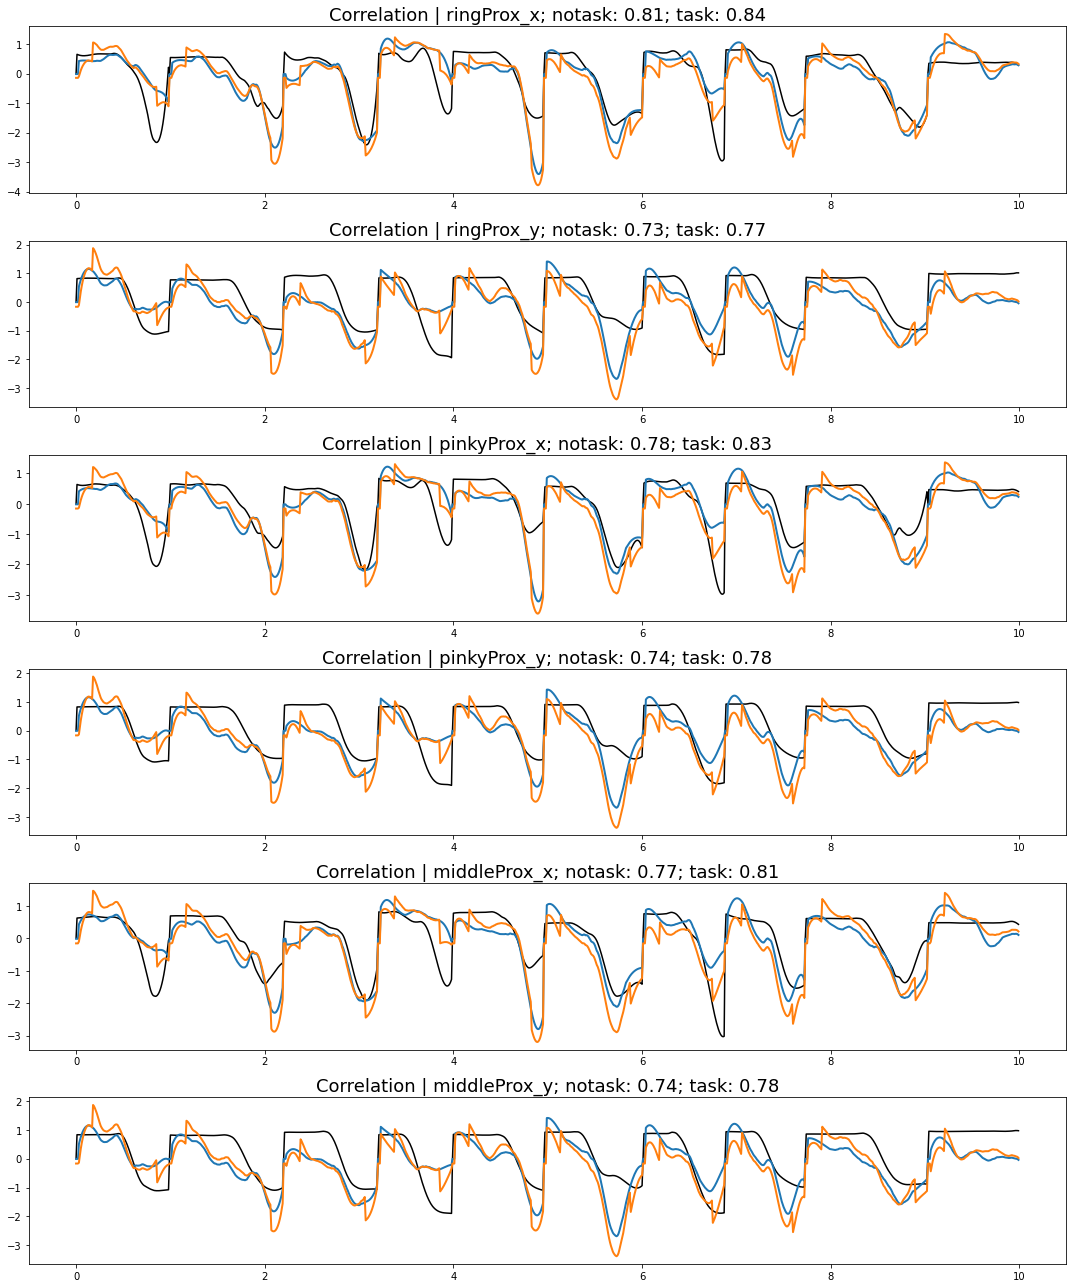

In [18]:
tstart = 0
bounds = np.arange(tstart, tstart + 1000)
x_vals = np.arange(len(bounds))/100

# decoder_type = 'rnn'
decoder_type = 'wiener'
cond1 = 'notask'
cond2 = 'task'

#marker_names = ['Carpal X', 'Carpal Y', 'Radius X', 'Radius Y', 'Ulnar X', 'Ulnar Y']
marker_names = np.concatenate([[f'{mrk}_x', f'{mrk}_y'] for mrk in marker_list])

plt.figure(figsize=(15, 3*(len(marker_names))))
for col_idx in range(len(marker_names)):
    plt.subplot(len(marker_names), 1, col_idx+1)
    plt.plot(x_vals, y_test_data[bounds, col_idx], color='k', label='DLC marker')
    plt.plot(x_vals, decode_results[decoder_type][cond1]['test_pred'][bounds, col_idx], color='C0', linewidth=2, label=cond1)
    plt.plot(x_vals, decode_results[decoder_type][cond2]['test_pred'][bounds, col_idx], color='C1', linewidth=2, label=cond2)


    cond1_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    cond2_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"Correlation | {marker_names[col_idx]}; {cond1}: {cond1_corr}; {cond2}: {cond2_corr}", fontsize=18)
    
    # if col_idx == 1:
    #     plt.xlabel('Time (s)', fontsize=16)
    # else:
    #     plt.xticks([])

    # if col_idx == 5:
    #     plt.legend()
    
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    
    #plt.vlines(x=[3, 6, 9, 12],ymin=-10000, ymax=100000, color='k', linewidth=10, linestyle='-', alpha=0.3)
plt.tight_layout()
# plt.savefig(f'movement_decoding_trajectory_{num_neurons}_neurons_layout.png')

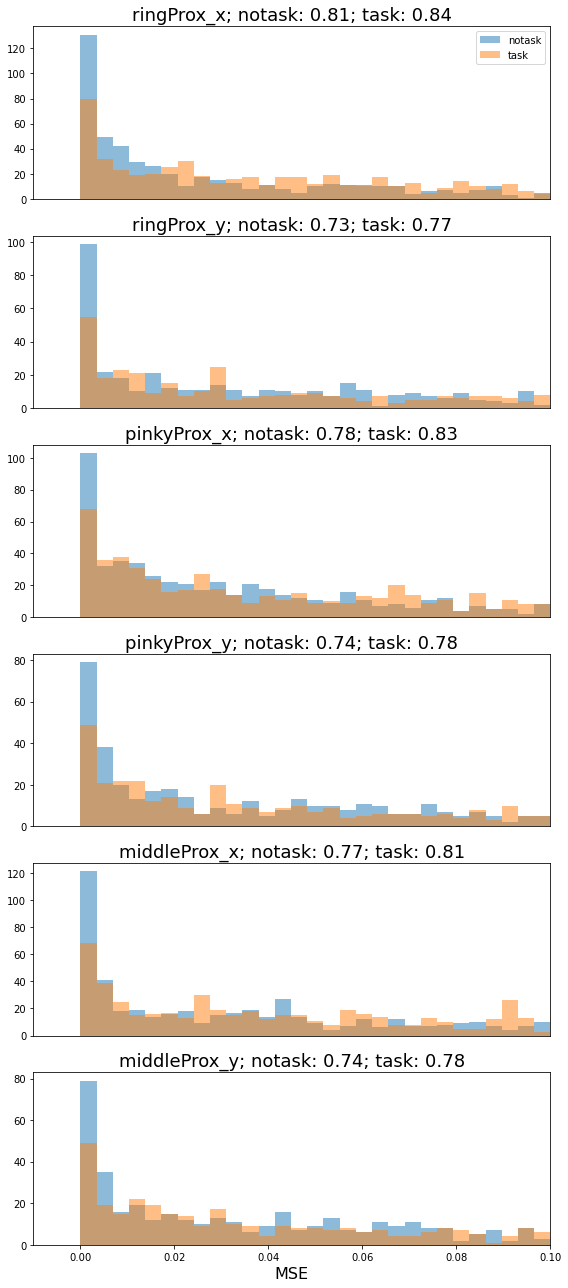

In [19]:
plt.figure(figsize=(8, 3*(len(marker_names))))
tstart = 300

# decoder_type = 'rnn'
decoder_type = 'wiener'

bins = np.linspace(0,0.1,30)
for col_idx in range(len(marker_names)):
    plt.subplot(len(marker_names), 1, col_idx+1)
    cond1_mse = np.square(decode_results[decoder_type][cond1]['test_pred'][:, col_idx] - y_test_data[:, col_idx])
    cond2_mse = np.square(decode_results[decoder_type][cond2]['test_pred'][:, col_idx] - y_test_data[:, col_idx])

    plt.hist(cond1_mse, color='C0', linewidth=2, label=cond1, bins=bins, alpha=0.5)
    plt.hist(cond2_mse, color='C1', linewidth=2, label=cond2, bins=bins, alpha=0.5)

    cond1_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    cond2_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"{marker_names[col_idx]}; {cond1}: {cond1_corr}; {cond2}: {cond2_corr}", fontsize=18)
    
    if col_idx == len(marker_names) - 1:
        plt.xlabel('MSE', fontsize=16)
    else:
        plt.xticks([])
    
    if col_idx == 0:
        plt.legend()
    
    #plt.ylim(plt.ylim(0, 4000))
    plt.xlim(plt.xlim(-0.01, bins[-1]))
    
plt.tight_layout()
# plt.savefig(f'movement_decoding_mse_{num_neurons}_neurons_layout.png')

(-0.05, 1.1)

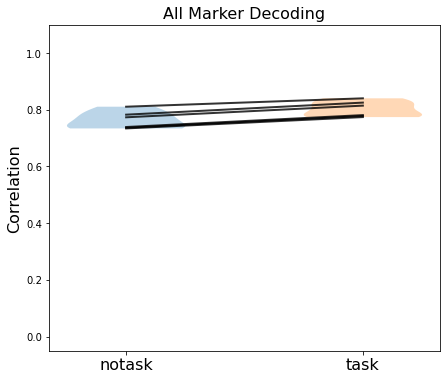

In [20]:
nolayout_test_corr = decode_results[decoder_type][cond1]['test_corr']
all_test_corr = decode_results[decoder_type][cond2]['test_corr']

plt.figure(figsize=(7,6))
plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=[cond1, cond2], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.title('All Marker Decoding', fontsize=16)
plt.ylim([-0.05,1.1])
# plt.savefig(f'movement_decoding_violin_{num_neurons}_neurons_layout.png')

(-0.05, 1.1)

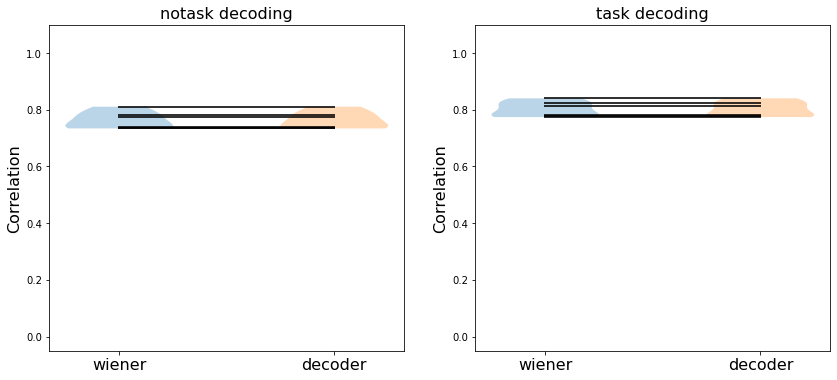

In [21]:

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
decoder_test_corr = decode_results[decoder_type][cond1]['test_corr']
wiener_test_corr = decode_results['wiener'][cond1]['test_corr']
plot_data = np.stack([wiener_test_corr, decoder_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['wiener', 'decoder'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(wiener_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(decoder_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.title(f'{cond1} decoding', fontsize=16)
plt.ylim([-0.05,1.1])

plt.subplot(1,2,2)
decoder_test_corr = decode_results[decoder_type][cond2]['test_corr']
wiener_test_corr = decode_results['wiener'][cond2]['test_corr']
plot_data = np.stack([wiener_test_corr, decoder_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['wiener', 'decoder'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(wiener_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(decoder_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.title(f'{cond2} decoding', fontsize=16)
plt.ylim([-0.05,1.1])
# plt.savefig(f'movement_decoding_violin_{num_neurons}_neurons_layout.png')

In [22]:
# plot_unit_idx = range(num_neurons)
# plt.figure(figsize=(7, 4*len(plot_unit_idx)))
# count = 1
# for unit_idx in plot_unit_idx:
#     plt.subplot(len(plot_unit_idx), 1, count)
#     for trial_idx in range(num_trials_filtered):
#         plot_df = neural_df[neural_df['unit'] == str(random_units[unit_idx])]
#         plot_color = plot_df['position'].values[trial_idx]
#         plt.plot(plot_df['rates'].values[trial_idx], color=f'C{plot_color -1}')
#         plt.title(f'Unit {random_units[unit_idx]}')
#     count+=1

# plt.suptitle('goCON -> endhold')

In [23]:
task_neural_df['layout'].str + task_neural_df['position'].str

AttributeError: Can only use .str accessor with string values!

In [ ]:
# plt.figure(figsize=(14,6))
# plt.subplot(1,2,1)
# plot_data = np.stack([proxjoint_test_corr, all_test_corr, finger_test_corr])
# _ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
# plt.xticks([0, 1, 2], labels=['ProxJoint', 'Combined', 'Finger'], fontsize=16)
# plt.ylabel('Correlation', fontsize=16)
# plt.violinplot(proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
# plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.violinplot(finger_test_corr, positions=[2], showmeans=False,showextrema=False)
# plt.title('ProxJoint/Finger vs. Combined', fontsize=16)
# plt.ylim([-0.05,0.9])

# plt.subplot(1,2,2)
# plot_data = np.stack([finger_proxjoint_test_corr, all_test_corr, eyes_test_corr])
# _ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
# plt.xticks([0, 1, 2], labels=['Finger+ProxJoint', 'Combined', 'Eyes'], fontsize=16)
# plt.ylabel('Correlation', fontsize=16)
# plt.violinplot(finger_proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
# plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.violinplot(eyes_test_corr, positions=[2], showmeans=False,showextrema=False)
# plt.title('Finger+ProxJoint/Eyes vs. Combined', fontsize=16)
# plt.ylim([-0.05,0.9])

# plt.savefig('single_unit_pred_final.svg')

In [ ]:
# compare_data_list = [all_test_pred, eyes_test_pred, finger_test_pred, proxjoint_test_pred]
# compare_data_names = ['Combined', 'Eyes', 'Fingers', 'Forelimb']

# data_arrays, generators = make_generators(kinematic_df, neural_df, neural_offset=20)
    
# # Unpack tuple into variables
# training_set, validation_set, testing_set = data_arrays
# training_generator, training_eval_generator, validation_generator, testing_generator = generators

# X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
# y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

# X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
# y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

# #Testing Data
# plt.figure(figsize=(14,8))
# bounds = np.arange(0,1500)
# x_vals = np.arange(len(bounds))/100
# unit_list = [4, 8, 16]

# for row_idx, unit_idx in enumerate(unit_list):
#     for plot_idx, (compare_data, name) in enumerate(zip(compare_data_list, compare_data_names)):
#         plt.subplot(3,4, plot_idx+1 + (4*row_idx))
#         plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
#         plt.ylim(plt.ylim())
#         plt.plot(x_vals, compare_data[bounds,unit_idx], color=f'C{plot_idx + 1}')
#         plt.title(f'{name}: Unit {unit_idx}')
#         #plt.ylim([-3, 3.7])
        
#         if plot_idx == 0:
#             plt.ylabel('Firing Rate (a.u.)')
            
#         if row_idx == 2:
#             plt.xlabel('Time (s)')
#         else:
#             plt.xticks([])

#     plt.tight_layout()

In [ ]:
data_arrays, generators = mocap_functions.make_generators(
wrist_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=None, window_size=7,
flip_outputs=True)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

IndexError: index -1 is out of bounds for dimension 1 with size 0

,rates,rates_video,unit,trial,layout,position,count
0,"[24.775702398741814, 24.387261232784457, 23.92...","[23.722857024041577, 19.81514120048125, 23.002...",1,0,1,4,1641.129368
1,"[-1.3083536833258473, -0.6214566239893045, -0....","[0.0, 6.002007883534913e-16, 7.700186905870893...",50,0,1,4,589.238604
2,"[27.299617826559956, 24.743666733238186, 22.59...","[20.835654651713575, 23.69812021364784, 19.789...",57,0,1,4,3866.104068
3,"[1.0000000000000004, 1.0000000000000004, 1.000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",layout_1,0,1,4,95.000000
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",layout_2,0,1,4,0.000000
...,...,...,...,...,...,...,...
2052,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",layout_4,217,2,2,0.000000
2053,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",position_1,217,2,2,0.000000
2054,"[1.0000000000000004, 1.0000000000000004, 1.000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",position_2,217,2,2,83.000000
2055,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",position_3,217,2,2,0.000000
